# Recipe Recommender System - Data Wrangling & EDA

## Capstone Project Three: Springboard Data Science Career Track 

### Notebook by Manthan Desai

## Introduction:

## 1. Problem Statement:

Develop a robust recipe recommender system leveraging a comprehensive dataset of recipes and a corresponding dataset of user reviews. The goal is to enhance the culinary experience for users by creating a personalized recommendation engine that suggests recipes based on individual preferences and past review history. Addressing challenges such as data integration, user profiling, and algorithmic efficiency, the system should provide accurate and diverse recommendations while accommodating users with varying dietary preferences and cultural tastes. 

## 2. The Data:

The datasets are acquired from Kaggle.com
(https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions). 

Recipe Dataset:

 - name - Recipe name
 - id - Recipe ID
 - minutes - Recipe prep time in minutes
 - contributter_id - User ID
 - submitted - Date of recipe submission
 - tags - List of keywords associated with the recipe
 - Nutrition - List of values corresponding to different nutritional elements 
 - n_steps - Number of steps
 - steps - List of the recipe steps
 - description - Recipe description
 - ingredients - Recipe ingredients
 - n_ingredients - number of ingredients
 
Users dataset:

 - user_id - Unique user ID
 - recipe_id - Recipe ID
 - date - Date of review submission
 - rating - Numeric rating between 0-5
 - review - written review of the users

### Library Imports and Data Collection

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import re
from library.sb_utils import save_file

#ignore warning messages to ensure clean outputs
import warnings
warnings.filterwarnings('ignore')

In [2]:
recipes_df = pd.read_csv('../data/RAW_recipes.csv')
users_df = pd.read_csv('../data/RAW_interactions.csv')

### Data Wrangling & Feature Engineering for Recipes Dataset

In [3]:
recipes_df.head(3)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13


In [4]:
recipes_df.columns

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients'],
      dtype='object')

In [5]:
recipes_df.isnull().sum()

name                 1
id                   0
minutes              0
contributor_id       0
submitted            0
tags                 0
nutrition            0
n_steps              0
steps                0
description       4979
ingredients          0
n_ingredients        0
dtype: int64

In [6]:
recipes_df.dtypes

name              object
id                 int64
minutes            int64
contributor_id     int64
submitted         object
tags              object
nutrition         object
n_steps            int64
steps             object
description       object
ingredients       object
n_ingredients      int64
dtype: object

The data doesn't have missing values for any useful columns thus imputation is not necessary. The description column does not contain any valuable information which is worth extracting, hence can be removed. Feature engineering remains critical for this dataset. The nutrition feature contains a list of 7 values for each record which can be seperated into individual columns for better analysis.

In [8]:
###convert the string nutrition list column into individual float columns
nutrition_df = recipes_df[['id','nutrition']]
nutrition_df[['nutrition_1', 'nutrition_2','nutrition_3','nutrition_4','nutrition_5','nutrition_6','nutrition_7']] = nutrition_df['nutrition'].str.split(',', expand=True)
nutrition_df.drop('nutrition', axis=1, inplace=True)

#remove [] characters from the first and last columns
nutrition_df['nutrition_1'] = nutrition_df['nutrition_1'].str.replace('[', '')
nutrition_df['nutrition_7'] = nutrition_df['nutrition_7'].str.replace(']', '')

#convert all columns to numeric data type
nutrition_df[['nutrition_1', 'nutrition_2','nutrition_3','nutrition_4','nutrition_5','nutrition_6','nutrition_7']] = nutrition_df[['nutrition_1', 'nutrition_2','nutrition_3','nutrition_4','nutrition_5','nutrition_6','nutrition_7']].apply(pd.to_numeric, errors='coerce')
nutrition_df.head()

,id,nutrition_1,nutrition_2,nutrition_3,nutrition_4,nutrition_5,nutrition_6,nutrition_7
0,137739,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,31490,173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,112140,269.8,22.0,32.0,48.0,39.0,27.0,5.0
3,59389,368.1,17.0,10.0,2.0,14.0,8.0,20.0
4,44061,352.9,1.0,337.0,23.0,3.0,0.0,28.0


The tags columns contains several keywords that can yield valuable information about each recipe such as the cuisine type, vegan or vegetarian

In [9]:
tags_df = recipes_df[['id','tags']]

tags_df['is_vegan'] = [int(string.find('vegan') != -1)for string in tags_df['tags']]
tags_df['is_vegetarian'] = [int(string.find('vegetarian') != -1)for string in tags_df['tags']]
tags_df.head()

,id,tags,is_vegan,is_vegetarian
0,137739,"['60-minutes-or-less', 'time-to-make', 'course...",0,1
1,31490,"['30-minutes-or-less', 'time-to-make', 'course...",0,0
2,112140,"['time-to-make', 'course', 'preparation', 'mai...",0,0
3,59389,"['60-minutes-or-less', 'time-to-make', 'course...",0,0
4,44061,"['weeknight', 'time-to-make', 'course', 'main-...",0,1


Note: Following cell takes 30+ mins to run

In [11]:
mapping_table = str.maketrans({'[': '', ']': '', "'": '', '-': ' '})
nlp = spacy.load("en_core_web_sm")
cuisine_types = ['north american','south american', 'asian','european','australian', 'african']
cuisine = []

for string in tags_df['tags']:
    string = string.translate(mapping_table)
    doc = nlp(string)
    norp_entries = [ent.text for ent in doc.ents if ent.label_ == 'NORP']
    if len(norp_entries) == 0:
        cuisine.append('')
    elif len(norp_entries) == 1:
        cuisine.append(norp_entries[0])
    else:
        el_found = False
        for element in cuisine_types:
            if element in norp_entries:
                cuisine.append(element)
                el_found = True
                break
        if(el_found == False):
            cuisine.append(norp_entries[0])
            
np.unique(cuisine)

array(['', 'african', 'asian', 'australian', 'cantonese', 'chinese',
       'egyptian', 'ethiopian', 'european', 'hawaiian', 'indian',
       'iranian', 'iraqi', 'japanese', 'jewish', 'lebanese', 'libyan',
       'mexican', 'moroccan', 'nigerian', 'north american', 'pakistani',
       'palestinian', 'saudi arabian', 'south african', 'south american',
       'turkish'], dtype='<U14')

In [12]:
tags_df['cuisine'] = cuisine
replace_values = {'cantonese': 'asian', 'chinese': 'asian', 'egyptian': 'african', 'ethiopian': 'african', 'hawaiian': 'north american', 'indian': 'asian', 'iranian': 'asian','iraqi': 'asian', 'japanese': 'asian', 'jewish': 'asian', 'lebanese': 'asian', 'libyan': 'african', 'mexican': 'north american', 'moroccan': 'african','nigerian': 'african', 'pakistani': 'asian', 'palestinian': 'asian', 'saudi arabian': 'asian', 'south african': 'african', 'turkish': 'european'}
tags_df = tags_df.replace({'cuisine': replace_values})
tags_df['cuisine'].unique()

array(['north american', '', 'asian', 'european', 'australian', 'african',
       'south american'], dtype=object)

In [13]:
tags_df.groupby('cuisine').describe()

id                                                   \
                   count           mean            std     min        25%   
cuisine                                                                     
                141577.0  226352.558707  136543.259940    38.0  106897.00   
african           2446.0  273927.103434  141436.661426  2155.0  169376.25   
asian            13297.0  224349.175227  147661.585383    39.0   92042.00   
australian        2377.0  246203.389567  130642.497106   651.0  141734.00   
european         21600.0  226234.454630  147000.072601    49.0  101002.25   
north american   49287.0  201775.280114  147645.216842    41.0   67797.50   
south american    1053.0  294891.125356  143732.194572    82.0  170591.00   

                                              is_vegan            ...       \
                     50%       75%       max     count      mean  ...  75%   
cuisine                                                           ...        
                216186.0  333146.0  537716.0  141577.0  0.034151  ...  0.0   
african         263298.0  415456.5  532742.0    2446.0  0.141455  ...  0.0   
asian           203982.0  343713.0  536973.0   13297.0  0.109874  ...  0.0   
australian      237207.0  352085.0  536728.0    2377.0  0.037021  ...  0.0   
european        204678.0  354365.0  537543.0   21600.0  0.043750  ...  0.0   
north american  173649.0  317071.5  536834.0   49287.0  0.045570  ...  0.0   
south american  307046.0  449529.0  536603.0    1053.0  0.086420  ...  0.0   

                    is_vegetarian                                               
                max         count      mean       std  min  25%  50%  75%  max  
cuisine                                                                         
                1.0      141577.0  0.118367  0.323043  0.0  0.0  0.0  0.0  1.0  
african         1.0        2446.0  0.309076  0.462207  0.0  0.0  0.0  1.0  1.0  
asian           1.0       13297.0  0.260435  0.438888  0.0  0.0  0.0  1.0  1.0  
australian      1.0        2377.0  0.231384  0.421806  0.0  0.0  0.0  0.0  1.0  
european        1.0       21600.0  0.235556  0.424355  0.0  0.0  0.0  0.0  1.0  
north american  1.0       49287.0  0.178850  0.383231  0.0  0.0  0.0  0.0  1.0  
south american  1.0        1053.0  0.209877  0.407414  0.0  0.0  0.0  0.0  1.0  

[7 rows x 24 columns]

Additional categorical columns can be created from the numerical minutes, n_steps, and n_ingredients that classify the numerical values into short, medium long labels based on set limits.

In [14]:
recipe_desc_df = recipes_df[['id','name','minutes', 'n_steps','n_ingredients']]

min_conditions = [recipe_desc_df['minutes'] <= 60, (recipe_desc_df['minutes'] > 60) & (recipe_desc_df['minutes'] <= 120), recipe_desc_df['minutes'] > 120]
values = ['Short','Medium','Long']
recipe_desc_df['Prep Time'] = np.select(min_conditions,values)

ing_conditions = [recipe_desc_df['n_ingredients'] <= 8, (recipe_desc_df['n_ingredients'] > 8) & (recipe_desc_df['n_ingredients'] <= 16), recipe_desc_df['n_ingredients'] > 16]
values = ['Short','Medium','Long']
recipe_desc_df['Ingredient List'] = np.select(min_conditions,values)

ing_conditions = [recipe_desc_df['n_steps'] <= 10, (recipe_desc_df['n_steps'] > 10) & (recipe_desc_df['n_steps'] <= 20), recipe_desc_df['n_steps'] > 20]
values = ['Short','Medium','Long']
recipe_desc_df['Recipe Process'] = np.select(min_conditions,values)

recipe_desc_df.head()

,id,name,minutes,n_steps,n_ingredients,Prep Time,Ingredient List,Recipe Process
0,137739,arriba baked winter squash mexican style,55,11,7,Short,Short,Short
1,31490,a bit different breakfast pizza,30,9,6,Short,Short,Short
2,112140,all in the kitchen chili,130,6,13,Long,Long,Long
3,59389,alouette potatoes,45,11,11,Short,Short,Short
4,44061,amish tomato ketchup for canning,190,5,8,Long,Long,Long


In [17]:
#combine all individual dfs created into one
tags_df.drop('tags',inplace=True, axis=1)
df = recipe_desc_df.merge(tags_df,left_on='id',right_on='id', how='left')
df = df.merge(nutrition_df, left_on='id',right_on='id',how='left')
df.head()

,id,name,minutes,n_steps,n_ingredients,Prep Time,Ingredient List,Recipe Process,is_vegan,is_vegetarian,cuisine,nutrition_1,nutrition_2,nutrition_3,nutrition_4,nutrition_5,nutrition_6,nutrition_7
0,137739,arriba baked winter squash mexican style,55,11,7,Short,Short,Short,0,1,north american,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,31490,a bit different breakfast pizza,30,9,6,Short,Short,Short,0,0,north american,173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,112140,all in the kitchen chili,130,6,13,Long,Long,Long,0,0,,269.8,22.0,32.0,48.0,39.0,27.0,5.0
3,59389,alouette potatoes,45,11,11,Short,Short,Short,0,0,,368.1,17.0,10.0,2.0,14.0,8.0,20.0
4,44061,amish tomato ketchup for canning,190,5,8,Long,Long,Long,0,1,north american,352.9,1.0,337.0,23.0,3.0,0.0,28.0


In [18]:
#save the cleaned dataframe as csv for the next steps
datapath = '../data'
save_file(df, 'recipe_data_cleaned.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  "../data\recipe_data_cleaned.csv"


### Data Wrangling for the Users dataset

In [28]:
users_df.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [19]:
users_df.columns

Index(['user_id', 'recipe_id', 'date', 'rating', 'review'], dtype='object')

In [20]:
users_df.isnull().sum()

user_id        0
recipe_id      0
date           0
rating         0
review       169
dtype: int64

In [21]:
users_df.dtypes

user_id       int64
recipe_id     int64
date         object
rating        int64
review       object
dtype: object

The users dataset is already polished as there are no missing values in all important columns. The review column can be dropped as there is no relevant information that could be extracted from it.

In [22]:
users_df.drop('review', inplace=True,axis=1)

In [23]:
#save the cleaned dataframe as csv for the next steps
datapath = '../data'
save_file(users_df, 'users_data_cleaned.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  "../data\users_data_cleaned.csv"


## Exploratory Data Analysis

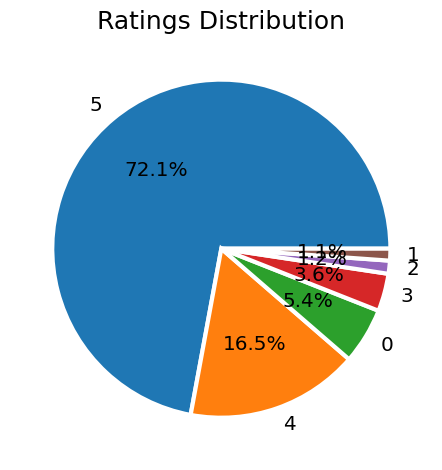

In [42]:
rating_counts = users_df['rating'].value_counts()
rating_percentages = pd.Series([(x / users_df.shape[0]) * 100.00 for x in rating_counts])

# #Construct a pie chart of the rating distributions
fig, ax = plt.subplots()
labels = ['5','4','0', '3','2','1']
ax.pie(rating_percentages, labels=labels, autopct='%.1f%%',wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
       textprops={'size': 'x-large'})
ax.set_title('Ratings Distribution',fontsize=18)
plt.tight_layout()

       n_steps bins
1-10         148914
11-20         70699
21-30          9858
30+            2165


Text(0.5, 1.0, 'n_steps Feature Distribution')

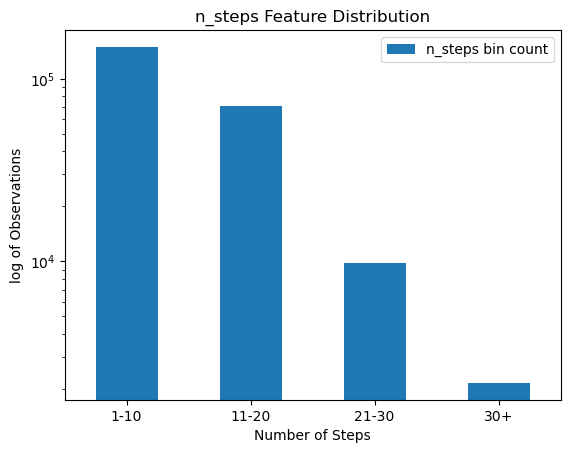

In [53]:
bin_range = ['1-10','11-20','21-30', '30+']
bins = pd.cut(df['n_steps'], [0,10,20,30,np.inf],right=True, labels=bin_range)

plot_df = pd.DataFrame({'n_steps bins': bins.value_counts(sort=False)}, index=bin_range)
print(plot_df)

#plot a bart chart of the binned data
plot_df.plot.bar(rot=0)
ax = plt.gca()
plt.yscale('log')
plt.legend(['n_steps bin count'])
plt.xlabel('Number of Steps')
plt.ylabel('log of Observations')
plt.title('n_steps Feature Distribution')

      n_ingredient bins
1-8              111790
9-16             111371
16+                8476


Text(0.5, 1.0, 'n_ingredient Feature Distribution')

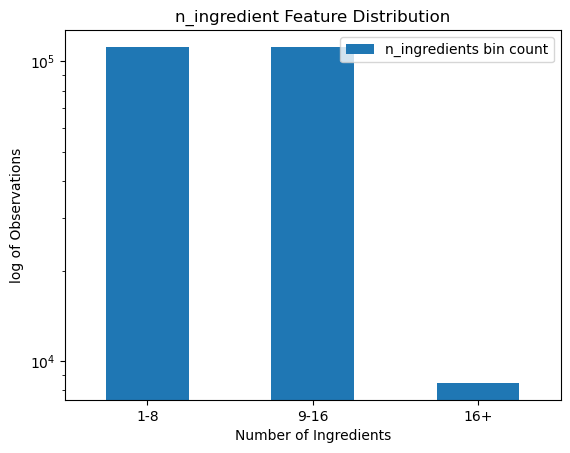

In [54]:
bin_range = ['1-8','9-16','16+']
bins = pd.cut(df['n_ingredients'], [0,8,16,np.inf],right=True, labels=bin_range)

plot_df = pd.DataFrame({'n_ingredient bins': bins.value_counts(sort=False)}, index=bin_range)
print(plot_df)

#plot a bart chart of the binned data
plot_df.plot.bar(rot=0)
ax = plt.gca()
plt.yscale('log')
plt.legend(['n_ingredients bin count'])
plt.xlabel('Number of Ingredients')
plt.ylabel('log of Observations')
plt.title('n_ingredient Feature Distribution')

        minutes bins
0-30           97959
31-60          70077
61-120         36683
120+           25824


Text(0.5, 1.0, 'minutes Feature Distribution')

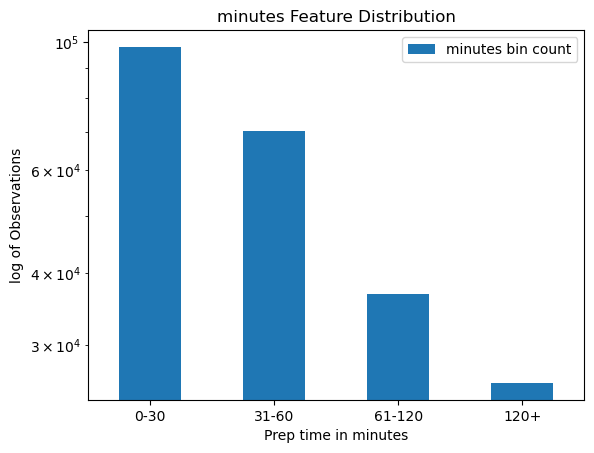

In [56]:
bin_range = ['0-30','31-60','61-120','120+']
bins = pd.cut(df['minutes'], [0,30,60,120,np.inf],right=True, labels=bin_range)

plot_df = pd.DataFrame({'minutes bins': bins.value_counts(sort=False)}, index=bin_range)
print(plot_df)

#plot a bart chart of the binned data
plot_df.plot.bar(rot=0)
ax = plt.gca()
plt.yscale('log')
plt.legend(['minutes bin count'])
plt.xlabel('Prep time in minutes')
plt.ylabel('log of Observations')
plt.title('minutes Feature Distribution')

Text(0.5, 1.0, 'Cuisine Feature Distribution')

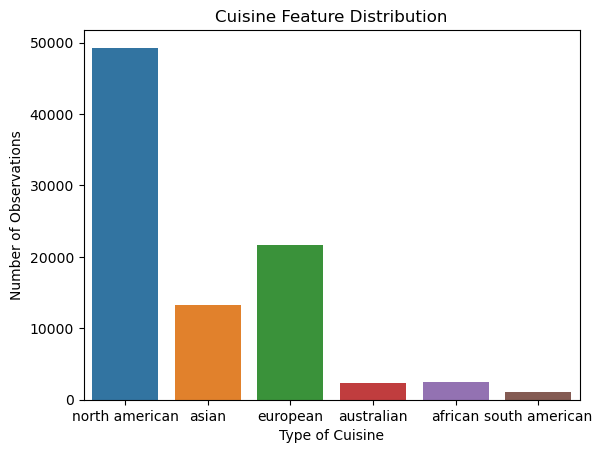

In [64]:
sns.countplot(data=df[-(df.cuisine == '')], x='cuisine')
plt.xlabel('Type of Cuisine')
plt.ylabel('Number of Observations')
plt.title('Cuisine Feature Distribution')